# MBA FIAP MLOps
## Treino Modelo Liveness Detection

### 1. Preparação do código
#### 1.1 Pacotes

In [2]:
##BIBLIOTECAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from collections import defaultdict

from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from keras.utils import plot_model
from keras.utils import  to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import Input
from tensorflow.keras.utils import to_categorical
import random
import os
from PIL import Image

#### 1.2 URL Treino

In [3]:
tr_real = '../src/data/train/real'
tr_spoof = '../src/data/train/spoof'
vl_real = '../src/data/valid/real'
vl_spoof = '../src/data/valid/spoof'

### 2. Preparação dos dados
#### 2.1 Leitura das imagens

In [12]:
#Leitura imagens base imagens reais
#tr_img_real = []
#for arq in os.listdir(tr_real):
#    if arq.endswith('.png'):
#        url_arq = os.path.join(tr_real, arq)
#        with Image.open(url_arq) as imagem:
#            tr_img_real.append(imagem)

tr_img_real = []
for arq in os.listdir(tr_real):
    if arq.endswith('.png'):
        url_arq = os.path.join(tr_real, arq)
        imagem = Image.open(url_arq)
        tr_img_real.append(imagem)


#tr_img_spoof = []
#for arq in os.listdir(tr_spoof):
#    if arq.endswith('.png'):
#        url_arq = os.path.join(tr_spoof, arq)
#        with Image.open(url_arq) as imagem:
#            tr_img_spoof.append(imagem)

tr_img_spoof = []
for arq in os.listdir(tr_spoof):
    if arq.endswith('.png'):
        url_arq = os.path.join(tr_spoof, arq)
        imagem = Image.open(url_arq)
        tr_img_spoof.append(imagem)


#vl_img_real = []
#for arq in os.listdir(vl_real):
#    if arq.endswith('.png'):
#        url_arq = os.path.join(vl_real, arq)
#        with Image.open(url_arq) as imagem:
#            vl_img_real.append(imagem)

vl_img_real = []
for arq in os.listdir(vl_real):
    if arq.endswith('.png'):
        url_arq = os.path.join(vl_real, arq)
        imagem = Image.open(url_arq)
        vl_img_real.append(imagem)


#vl_img_spoof = []
#for arq in os.listdir(vl_spoof):
#    if arq.endswith('.png'):
#        url_arq = os.path.join(vl_spoof, arq)
#        with Image.open(url_arq) as imagem:
#            vl_img_spoof.append(imagem)

vl_img_spoof = []
for arq in os.listdir(vl_spoof):
    if arq.endswith('.png'):
        url_arq = os.path.join(vl_spoof, arq)
        imagem = Image.open(url_arq)
        vl_img_spoof.append(imagem)


Número de imagens em vl_img_spoof: 468
Número de imagens em vl_img_spoof: 1636
Número de imagens em vl_img_spoof: 574
Número de imagens em vl_img_spoof: 1335


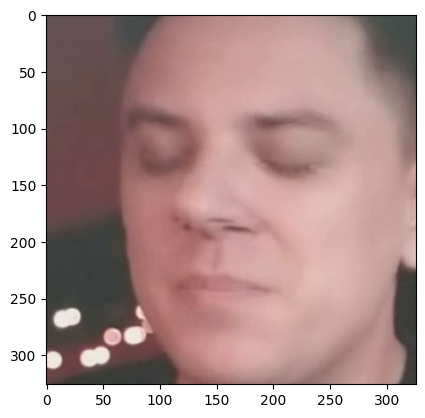

In [13]:
#Validações
# Verificar o comprimento da lista
print("Número de imagens em vl_img_spoof:", len(tr_img_real))
print("Número de imagens em vl_img_spoof:", len(tr_img_spoof))
print("Número de imagens em vl_img_spoof:", len(vl_img_real))
print("Número de imagens em vl_img_spoof:", len(vl_img_spoof))

#plt.imshow(vl_img_spoof[1])
import matplotlib.pyplot as plt

# Supondo que vl_img_spoof[1] seja uma imagem que você deseja exibir
plt.imshow(vl_img_spoof[1])
plt.show()


#### 2.2 Procesamento dos dados para treino

In [14]:
#Conversão e padronização dos tamanhos
#def conv_img(image_list, size=(256, 256)):
#    resized_images = []
#    for img in image_list:
#        try:
#            if isinstance(img, Image.Image):  # Verificar se é um objeto PIL
#                img = img.resize(size)
#                img = np.array(img)
#            resized_images.append(img)
#        except Exception as e:
#            print(f"Erro ao processar imagem: {e}")
#    return np.array(resized_images)

def conv_img(image_list, size=(128, 128)):
    resized_images = []
    for img in image_list:
        try:
            if isinstance(img, Image.Image):  # Verificar se é um objeto PIL
                img = img.resize(size)
                img = np.array(img)
                # Normalizar a imagem de 0-255 para 0-1 enquanto a imagem é carregada
                img = img / 255.0
            resized_images.append(img)
        except Exception as e:
            print(f"Erro ao processar imagem: {e}")
    return np.array(resized_images)


#Usando função
tr_img_real = conv_img(tr_img_real)
tr_img_spoof = conv_img(tr_img_spoof)
vl_img_real = conv_img(vl_img_real)
vl_img_spoof = conv_img(vl_img_spoof)

# Rotulando imagens: Fake = 1; Real = 0
y_img_real_tr = np.zeros(len(tr_img_real))
y_img_real_vl = np.zeros(len(vl_img_real))
y_img_spoof_tr = np.ones(len(tr_img_spoof))
y_img_spoof_vl = np.ones(len(vl_img_spoof))

# Concatenar as imagens e rótulos
X_tr = np.concatenate((tr_img_real, tr_img_spoof), axis=0)
Y_tr = np.concatenate((y_img_real_tr, y_img_spoof_tr), axis=0)
X_te = np.concatenate((vl_img_real, vl_img_spoof), axis=0)
Y_te = np.concatenate((y_img_real_vl, y_img_spoof_vl), axis=0)

# Normaliza as entradas de 0-255 para 0-1
#X_tr = X_tr/255.0
#X_te = X_te/255.0


# Embaralhar os índices
ind_tr = np.random.permutation(len(X_tr))
ind_te = np.random.permutation(len(X_te))

# Aplicar as permutações aos dados de entrada e rótulos de treinamento
X_tr_ind, Y_tr_ind = X_tr[ind_tr], Y_tr[ind_tr]

# Aplicar as permutações aos dados de entrada e rótulos de teste
X_te_ind, Y_te_ind = X_te[ind_te], Y_te[ind_te]


# Redimensionar os dados de treinamento
X_tr_ind2 = X_tr_ind.reshape(-1, 128, 128, 3)

# Redimensionar os dados de teste
X_te_ind2 = X_te_ind.reshape(-1, 128, 128, 3)

In [7]:
print(len(X_tr_ind))
print(len(Y_tr_ind))
print(len(X_te_ind))
print(len(Y_te_ind))

print(len(X_tr_ind2))
print(len(X_te_ind2))


506
506
1909
1909
506
1909


### 3. Treino do modelo
#### 3.1. Configuração hiperparâmetros

In [8]:
#Camada de entrada
input_shape=(512, 512, 3)
inputs = Input(shape=input_shape)

#Arquitetura da rede
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),  activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),  activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='../models/livenss_param.keras', verbose=1,  save_best_only=True, monitor='val_accuracy')

hist = model.fit(X_tr_ind2, Y_tr_ind, batch_size=100, epochs=5, validation_data=(X_te_ind2, Y_te_ind), callbacks=[checkpointer], verbose=1, shuffle=True)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5372 - loss: 20.2415 
Epoch 1: val_accuracy improved from -inf to 0.69932, saving model to ../models/livenss_param.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 168s 31s/step - accuracy: 0.5378 - loss: 19.3697 - val_accuracy: 0.6993 - val_loss: 1.6118
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6978 - loss: 1.0706 
Epoch 2: val_accuracy did not improve from 0.69932
6/6 ━━━━━━━━━━━━━━━━━━━━ 94s 16s/step - accuracy: 0.6924 - loss: 1.0430 - val_accuracy: 0.3038 - val_loss: 0.7328
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6533 - loss: 0.6658 
Epoch 3: val_accuracy did not improve from 0.69932
6/6 ━━━━━━━━━━━━━━━━━━━━ 102s 18s/step - accuracy: 0.6639 - loss: 0.6609 - val_accuracy: 0.6527 - val_loss: 0.6769
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7347 - loss: 0.5632 
Epoch 4: val_accuracy did not improve from 0.69932
6/6 ━━━━━━━━━━━━━━━━━━━━ 92s 16s/step - accuracy: 0.7350 - loss: 0.5587 - 

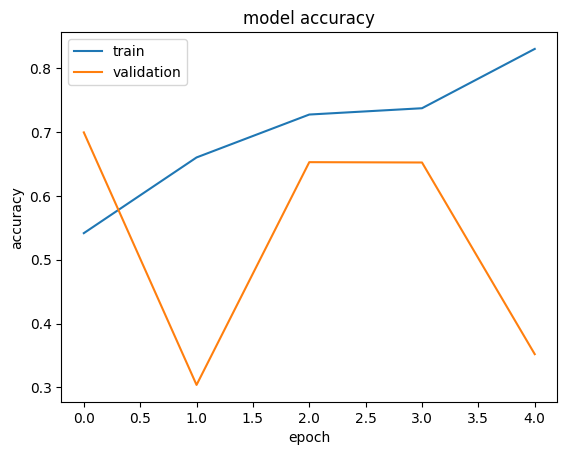

In [11]:
plt.figure(1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
#Validação 1
#tr_img_real = tr_img_real.tolist()  # Convertendo para lista
#with Image.open(url_arq) as imagem:
#    print(f"Imagem carregada: {imagem}")
#    tr_img_real.append(imagem)


print("Verificando os dados de treinamento e validação:")
print("Shapes dos dados de treinamento:", X_tr_ind.shape, Y_tr_ind.shape)
print("Shapes dos dados de validação:", X_te_ind.shape, Y_te_ind.shape)

# Verificar se os valores estão dentro do intervalo esperado (0 a 1)
print("Valor mínimo e máximo nos dados de treinamento:", np.min(X_tr_ind), np.max(X_tr_ind))
print("Valor mínimo e máximo nos dados de validação:", np.min(X_te_ind), np.max(X_te_ind))


Verificando os dados de treinamento e validação:
Shapes dos dados de treinamento: (0, 512, 512, 3) (0,)
Shapes dos dados de validação: (0, 512, 512, 3) (0,)


ValueError: zero-size array to reduction operation minimum which has no identity

In [31]:
print()

print("Valor mínimo e máximo nos dados de treinamento:", np.min(X_tr), np.max(X_tr))


ValueError: zero-size array to reduction operation minimum which has no identity